<a href="https://www.kaggle.com/code/pjmathematician/amazon-ml-challenge-2023-winner-solution?scriptVersionId=127710494" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ART in Artificial Intelligence 

Hi! I am Poojan Vachharajani (aka @pjmathematican), one of the members of the team ART in the Artificial Intelligence for the Amazon ML Challenge 2023. My teammates were [@chaitanyagiri](https://www.kaggle.com/chaitanyagiri) , [@harshitkmr](https://www.kaggle.com/harshitkmr) , and [@anshtanwar](https://www.kaggle.com/anshtanwar).

After receiving a ton of requests to share our approach, I am sharing this notebook that outlines our solution without revealing any part of the data that was shared (TnC do not allow us to share the training or testing data).

Feel free to reach out to me either here via comments or on LinkedIn!


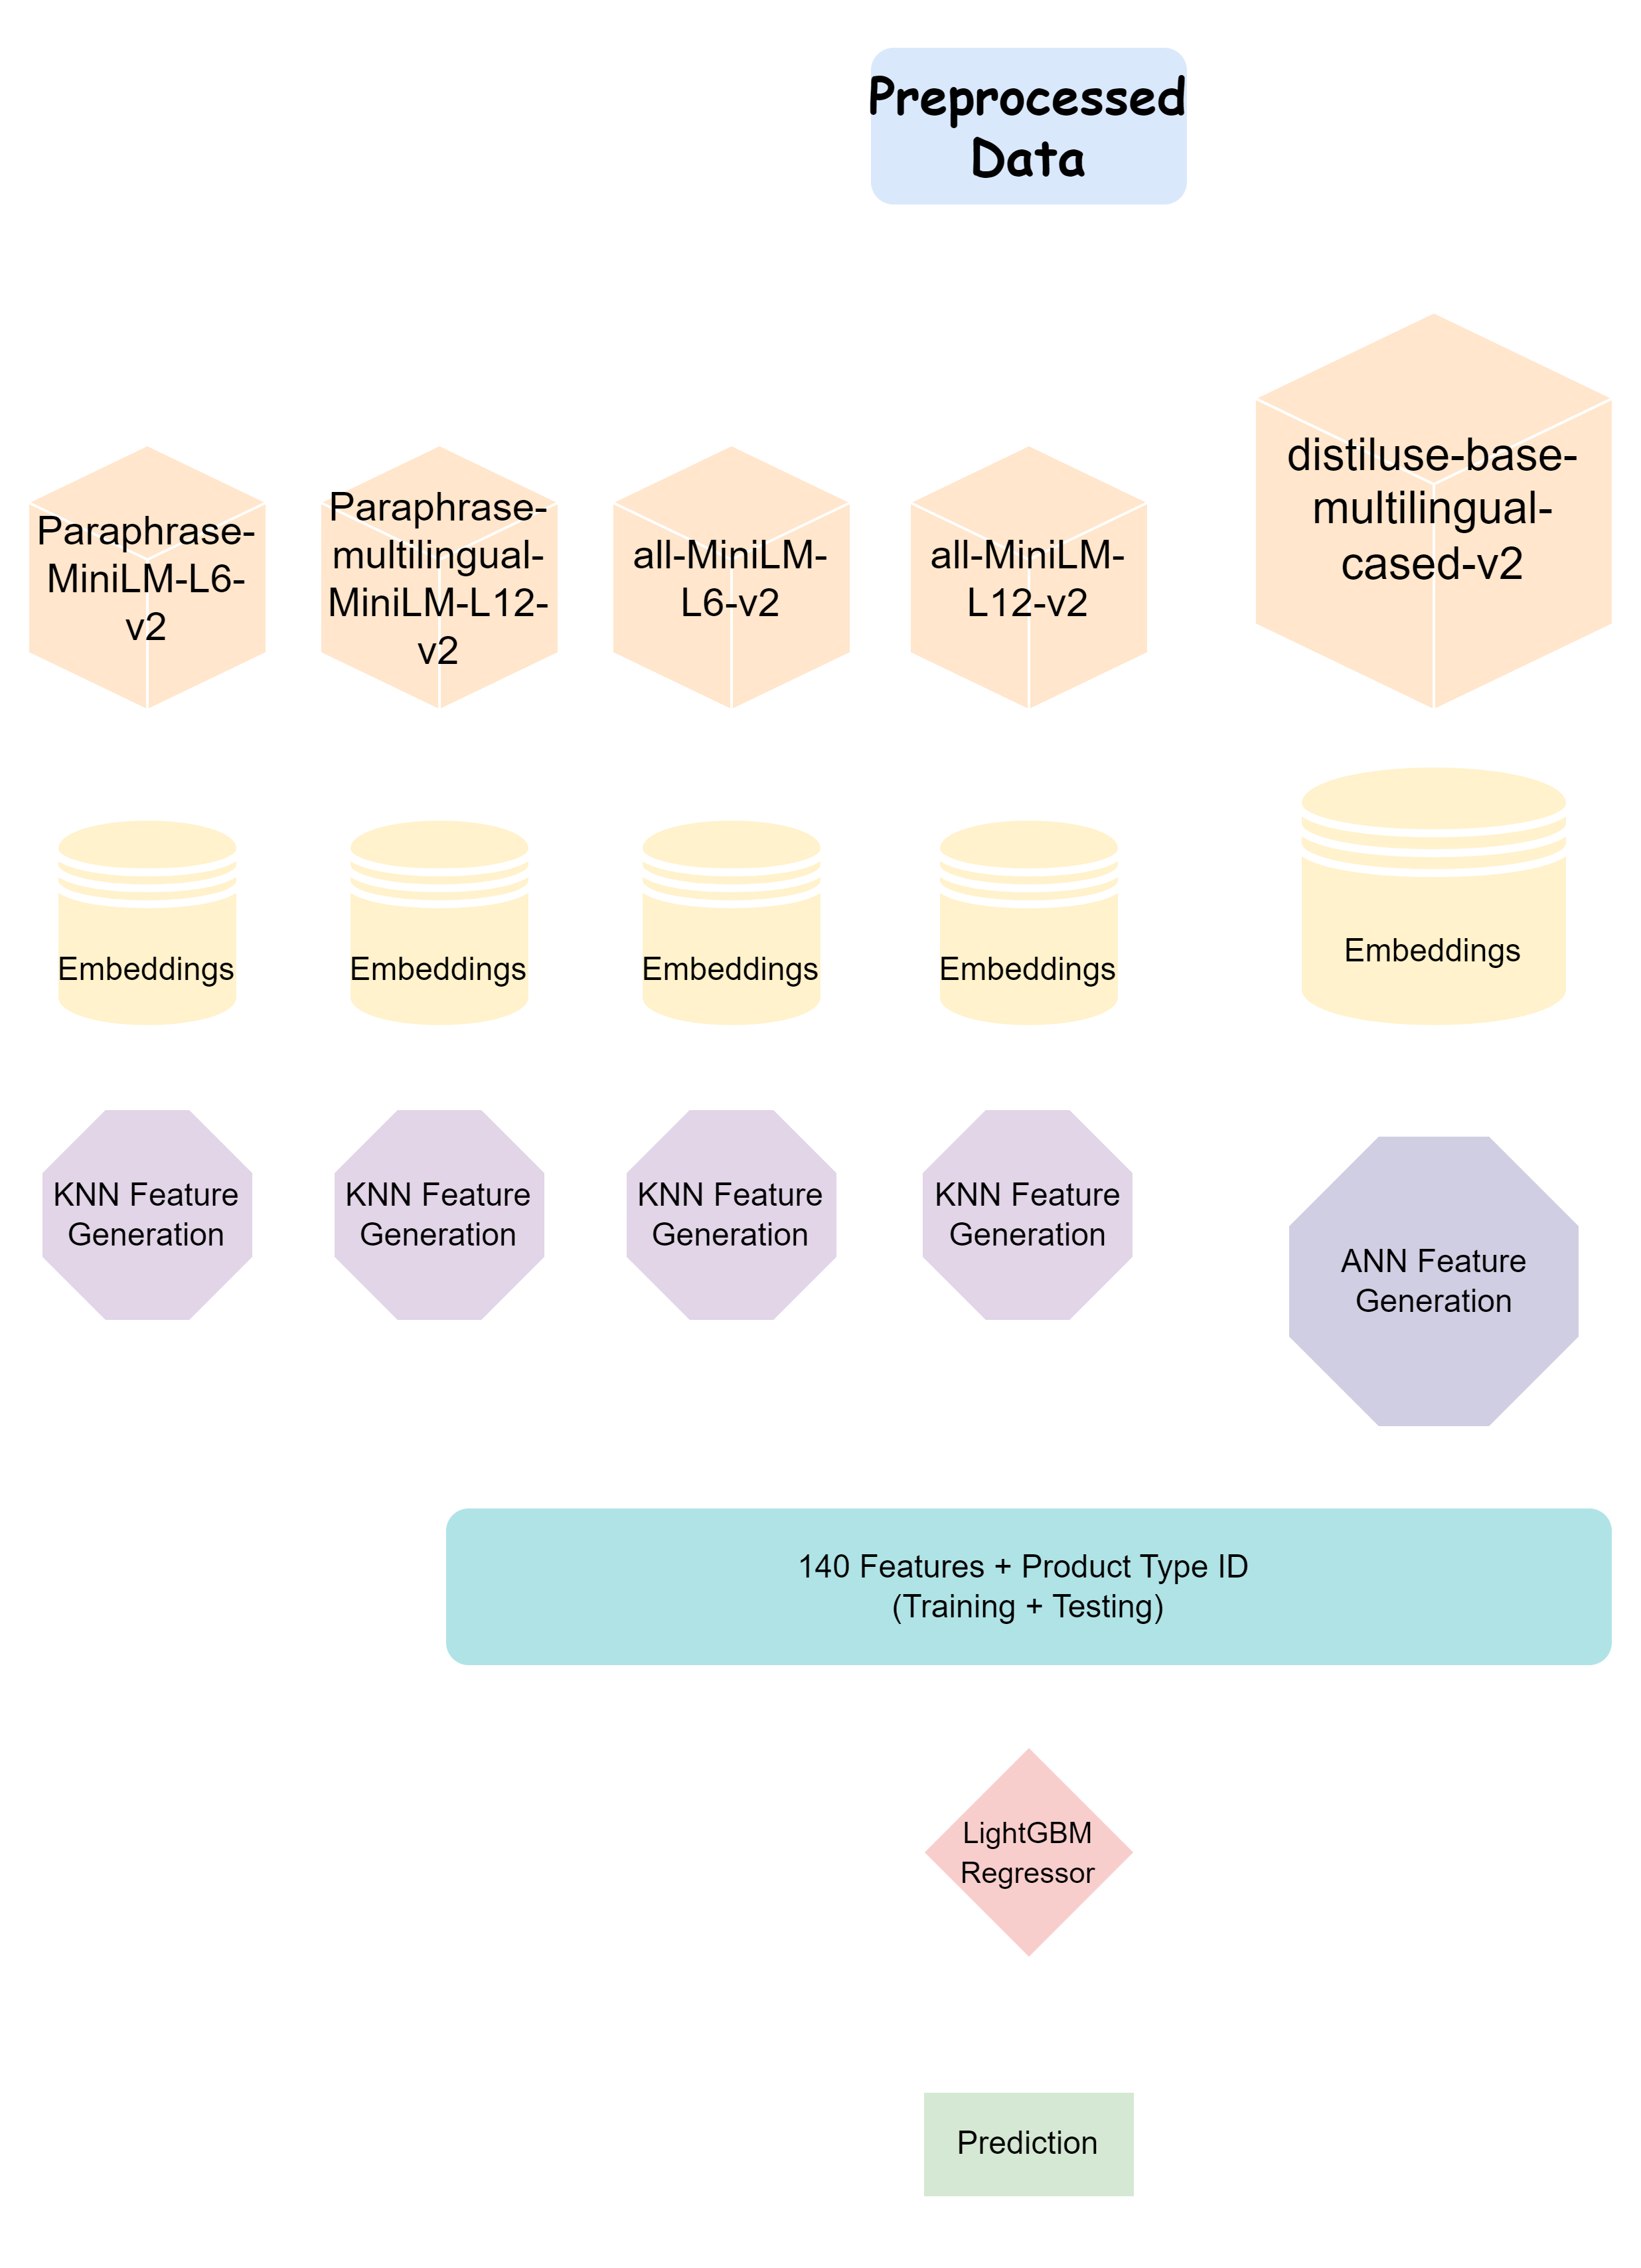

## 1. Importing and installing required libraries

In [1]:
%%capture
!pip install hnswlib
!pip install sentence-transformers
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch
from sentence_transformers import SentenceTransformer, util
import lightgbm
import hnswlib

## 2. Importing training, testing and submission files
will be using only the first 1000 rows 

In [2]:
train = pd.read_csv('/kaggle/input/amazon-ml-challenge-2023/dataset/train.csv', nrows = 1000).fillna(' ')
test = pd.read_csv('/kaggle/input/amazon-ml-challenge-2023/dataset/test.csv', nrows = 1000).fillna(' ')
sample_submission = pd.read_csv('/kaggle/input/amazon-ml-challenge-2023/dataset/sample_submission.csv', nrows = 1000).fillna(' ')

## 3. Download and load language models

In [3]:
%%capture
p_mlm_l6_v2 = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')
p_ml_mlm_l12_v2 = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
a_mlm_l6_v2 = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
a_mlm_l12_v2 = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')

distil_ml_base_v2 = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')

## 4. Generate and normalize embeddings for the whole data

(Here, we concatenate the 3 text columns)

In [4]:
embeddings = {}
for name, model in zip(['p_mlm_l6_v2', 'p_ml_mlm_l12_v2', 'a_mlm_l6_v2', 'a_mlm_l12_v2', 'distil_ml_base_v2'], [p_mlm_l6_v2, p_ml_mlm_l12_v2, a_mlm_l6_v2, a_mlm_l12_v2, distil_ml_base_v2]):
    corpus_embeddings = model.encode((train['TITLE'] + " " + train['BULLET_POINTS'] + " " + train["DESCRIPTION"]), convert_to_tensor=True, batch_size = 32)
    query_embeddings = model.encode((test['TITLE'] + " " + test['BULLET_POINTS'] + " " + test["DESCRIPTION"]), convert_to_tensor=True, batch_size = 32)
    embeddings[name] = (corpus_embeddings, query_embeddings)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

## Generate KNNs
Top 10 - KNNs are generated using 20% training data from the remaining 80% training data. And their corresponding PRODUCT_LENGTHs are mapped and stored. For all the 'mlm' models.

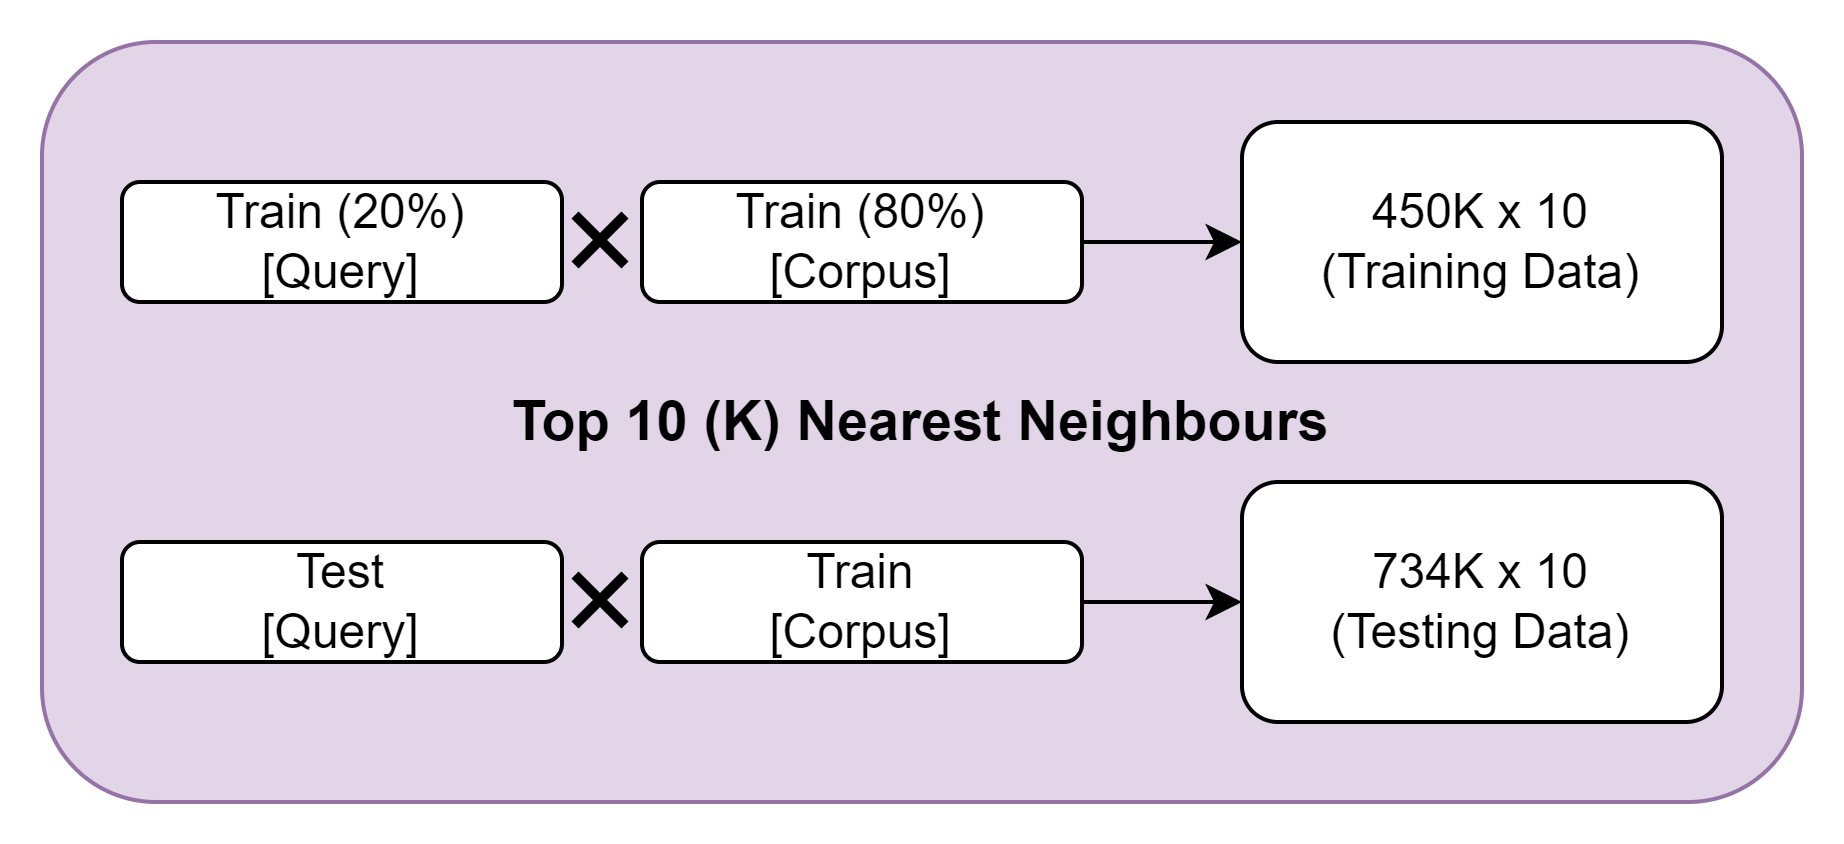

In [5]:
KNN_dataframes_train = []
KNN_dataframes_test = []
for model in ['p_mlm_l6_v2', 'p_ml_mlm_l12_v2', 'a_mlm_l6_v2', 'a_mlm_l12_v2']:
    size = embeddings[model][0].shape[0]
    corpus_train = embeddings[model][0][0:int(size*0.8)]
    query_train = embeddings[model][0][int(size*0.8):]
    full_train = embeddings[model][0]
    full_test = embeddings[model][1]
    KNN_train = util.semantic_search(query_train, corpus_train, top_k = 10, score_function=util.dot_score, query_chunk_size=1000, corpus_chunk_size=1000)
    indices_train = [[i['corpus_id'] for i in j] for j in KNN_train]
    KNN_df_train = pd.DataFrame(train['PRODUCT_LENGTH'].values[indices_train])
    KNN_dataframes_train.append(KNN_df_train)
    KNN_test = util.semantic_search(full_test, full_train, top_k = 10, score_function=util.dot_score, query_chunk_size=1000, corpus_chunk_size=1000)
    indices_test = [[i['corpus_id'] for i in j] for j in KNN_test]
    KNN_df_test = pd.DataFrame(train['PRODUCT_LENGTH'].values[indices_test])
    KNN_dataframes_test.append(KNN_df_test)

## Generate ANNs
Top 100 - ANNs are generated for the whole training data. And their corresponding PRODUCT_LENGTHs are mapped and stored. Only for the distilled model.

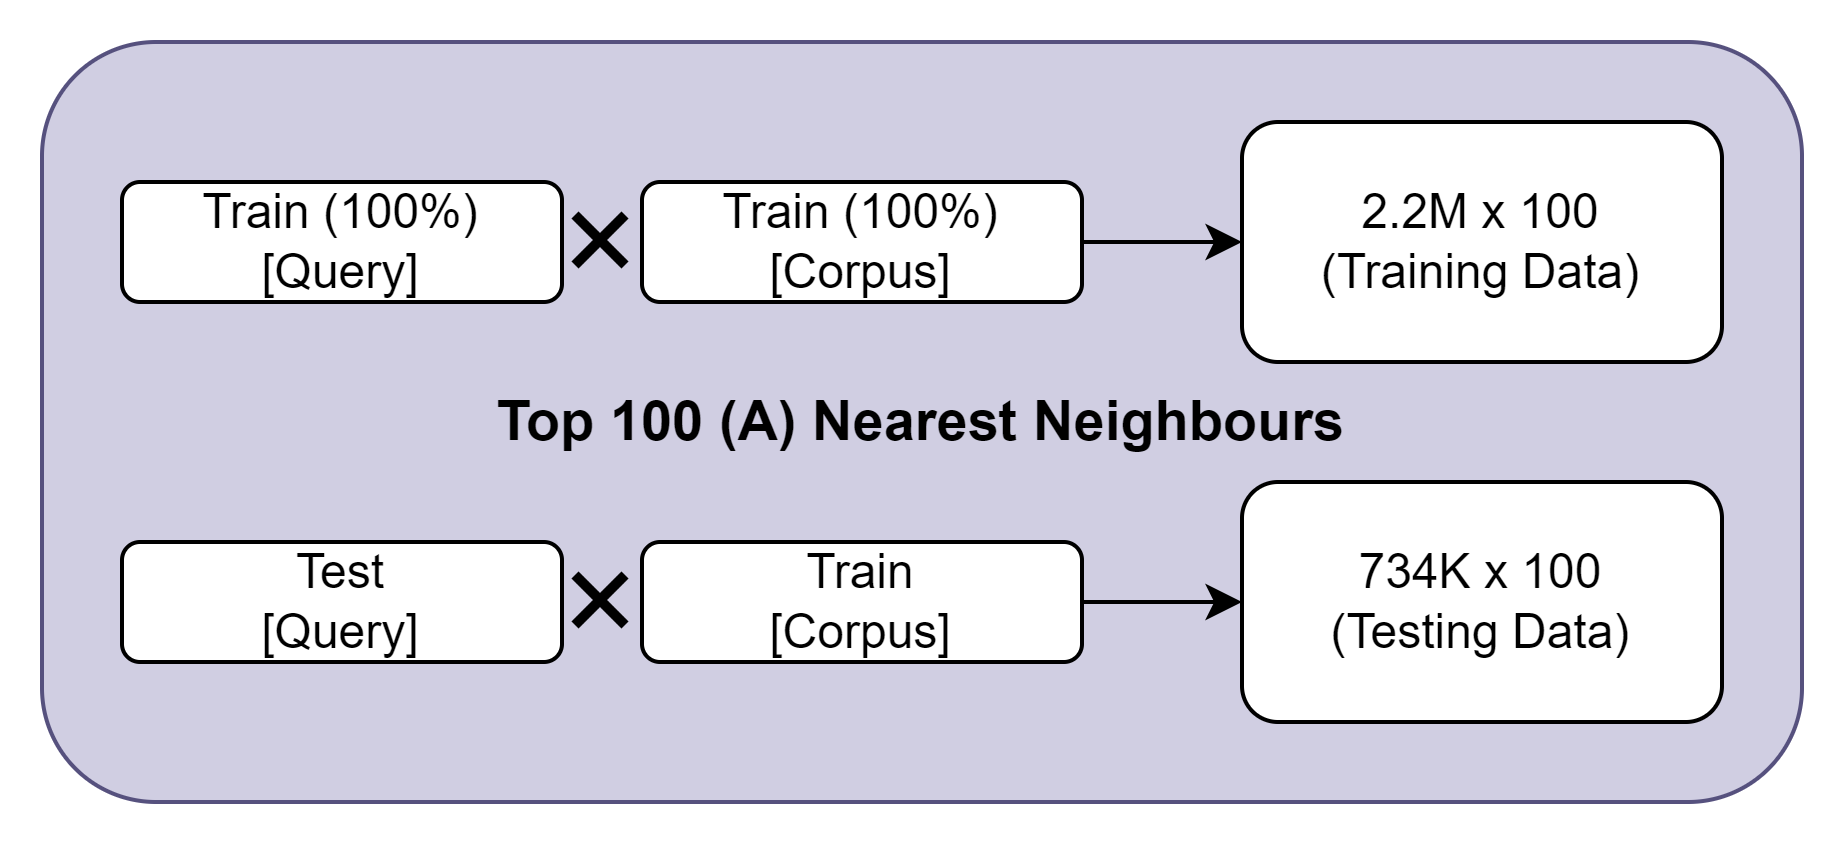

In [6]:
index = hnswlib.Index(space='cosine', dim=embeddings['distil_ml_base_v2'][0].shape[1])
index.init_index(max_elements=embeddings['distil_ml_base_v2'][0].shape[0], ef_construction=150, M=50)
index.add_items(embeddings['distil_ml_base_v2'][0].cpu())
index.set_ef(40)

ANN_indices_train = index.knn_query(embeddings['distil_ml_base_v2'][0].cpu(), k = 100)
ANN_indices_test = index.knn_query(embeddings['distil_ml_base_v2'][1].cpu(), k = 100)

ANN_df_train = pd.DataFrame(train['PRODUCT_LENGTH'].values[ANN_indices_train[0]])
ANN_df_test = pd.DataFrame(train['PRODUCT_LENGTH'].values[ANN_indices_test[0]])

## Concatenate the generated dataframes 

In [7]:
main_train = pd.concat(KNN_dataframes_train + [ANN_df_train.iloc[int(ANN_df_train.shape[0]*0.8):].reset_index(drop = True)], axis = 1)
main_train.columns = [f'f_{i}' for i in range(1, 141)]
main_train['target'] = train.iloc[int(train.shape[0]*0.8):].reset_index(drop = True)['PRODUCT_LENGTH']

main_test = pd.concat(KNN_dataframes_test + [ANN_df_test], axis = 1)
main_test.columns = [f'f_{i}' for i in range(1, 141)]

## Initialize LightGBM regressor with custom loss and hyperparameters

In [8]:
def custom_objective(y_true, y_pred):
    epsilon = 1e-8
    y_pred = np.maximum(y_pred, epsilon)
    grad = (np.log(y_pred) - np.log(y_true)) / y_pred
    hess = 1 / y_pred ** 2
    return grad, hess
model = lightgbm.LGBMRegressor(extra_trees = True, n_estimators = 5000, learning_rate = 0.08, max_depth = 15, num_leaves = 2**15, objective = custom_objective, device = 'gpu')

## Fit the model and infer

In [9]:
model.fit(main_train.iloc[:,:-1], main_train.iloc[:,-1])
preds = model.predict(main_test)
submission = sample_submission.copy()
submission['PRODUCT_LENGTH'] = preds
submission.to_csv('submission.csv', index = False)

In [10]:
!rm submission.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
